<a href="https://www.kaggle.com/code/samyamaryal1/ieee-cis?scriptVersionId=134082485" target="_blank"><img align="left" alt="Kaggle" title="Open in Kaggle" src="https://kaggle.com/static/images/open-in-kaggle.svg"></a>

In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import matplotlib
import matplotlib.pyplot as plt
import plotly.express as px
import seaborn as sns
# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/ieee-fraud-detection/sample_submission.csv
/kaggle/input/ieee-fraud-detection/test_identity.csv
/kaggle/input/ieee-fraud-detection/train_identity.csv
/kaggle/input/ieee-fraud-detection/test_transaction.csv
/kaggle/input/ieee-fraud-detection/train_transaction.csv


In [2]:
# Importing the datasets
train_identity = pd.read_csv('/kaggle/input/ieee-fraud-detection/train_identity.csv')
train_transaction = pd.read_csv('/kaggle/input/ieee-fraud-detection/train_transaction.csv')

The data is broken into two files: identity and transaction, which share a common column *TransactionID*. Not all transactions have corresponding identity information.

# Thorough inspection of all the datasets.

In [3]:
train_transaction.shape

(590540, 394)

In [4]:
train_identity.shape

(144233, 41)

In [5]:
train_identity.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 144233 entries, 0 to 144232
Data columns (total 41 columns):
 #   Column         Non-Null Count   Dtype  
---  ------         --------------   -----  
 0   TransactionID  144233 non-null  int64  
 1   id_01          144233 non-null  float64
 2   id_02          140872 non-null  float64
 3   id_03          66324 non-null   float64
 4   id_04          66324 non-null   float64
 5   id_05          136865 non-null  float64
 6   id_06          136865 non-null  float64
 7   id_07          5155 non-null    float64
 8   id_08          5155 non-null    float64
 9   id_09          74926 non-null   float64
 10  id_10          74926 non-null   float64
 11  id_11          140978 non-null  float64
 12  id_12          144233 non-null  object 
 13  id_13          127320 non-null  float64
 14  id_14          80044 non-null   float64
 15  id_15          140985 non-null  object 
 16  id_16          129340 non-null  object 
 17  id_17          139369 non-nul

In [6]:
train_transaction.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 590540 entries, 0 to 590539
Columns: 394 entries, TransactionID to V339
dtypes: float64(376), int64(4), object(14)
memory usage: 1.7+ GB


The train_transaction dataset has 394 columns.
According to the data description by IEEE,
* TransactionDT - timedelta from reference timestamp
* TransactionAMT - txn amount
* ProductCD - Product code
* card1-6 - payment card information (card type, category, issue bank, country,
* addr
* dist - distances between billing and mailing address
* emaildomain (Purchaser and Recipient)
* C1-14 - "counting"
* D1-15 - timedelta
* M1-9 - match
* Vxxx - Vesta engineered features, over 300 of these. (V1-V339)

- id01 to id11 are numerical features for identity, which is collected by Vesta and security partners such as device rating, ip_domain rating, proxy rating, etc.
- id_12 - id_38 are categorical features.

# Rename the two columns card4 and card6, because we can infer its meaning from the above dataframe.

In [7]:
train_transaction.loc[:, 'card1':'card6']

card1  card2  card3       card4  card5   card6
0       13926    NaN  150.0    discover  142.0  credit
1        2755  404.0  150.0  mastercard  102.0  credit
2        4663  490.0  150.0        visa  166.0   debit
3       18132  567.0  150.0  mastercard  117.0   debit
4        4497  514.0  150.0  mastercard  102.0  credit
...       ...    ...    ...         ...    ...     ...
590535   6550    NaN  150.0        visa  226.0   debit
590536  10444  225.0  150.0  mastercard  224.0   debit
590537  12037  595.0  150.0  mastercard  224.0   debit
590538   7826  481.0  150.0  mastercard  224.0   debit
590539  15066  170.0  150.0  mastercard  102.0  credit

[590540 rows x 6 columns]

In [8]:
# Renaming columns card4 and card6 as 'issuer' and 'type'
train_transaction.rename({'card4':'issuer', 'card6':'type'}, axis=1, inplace=True)

In [9]:
train_transaction.loc[:, 'card1':'type']

card1  card2  card3      issuer  card5    type
0       13926    NaN  150.0    discover  142.0  credit
1        2755  404.0  150.0  mastercard  102.0  credit
2        4663  490.0  150.0        visa  166.0   debit
3       18132  567.0  150.0  mastercard  117.0   debit
4        4497  514.0  150.0  mastercard  102.0  credit
...       ...    ...    ...         ...    ...     ...
590535   6550    NaN  150.0        visa  226.0   debit
590536  10444  225.0  150.0  mastercard  224.0   debit
590537  12037  595.0  150.0  mastercard  224.0   debit
590538   7826  481.0  150.0  mastercard  224.0   debit
590539  15066  170.0  150.0  mastercard  102.0  credit

[590540 rows x 6 columns]

# Function to remove null columns

In [10]:
threshold=100
print(f"LETS try {threshold} raw strings")

LETS try 100 raw strings


In [11]:
def drop_missing_values(original_df, missing_df):
    threshold=85
    extra = missing_df[missing_df['value']>threshold]
    index = list(extra.reset_index()['index'])
    print(len(index), f"columns have over {threshold}% missing values")
    original_df.drop(index, axis=1, inplace=True)
    return original_df

# Find the percentage of missing values in the dataframes *train_transaction* and *train_identity*.

In [12]:
# Determining the number of missing values in the train_transaction column, except the 'V' columns
transaction_missing_values = pd.DataFrame(train_transaction.loc[:, :'M9'].isnull().sum() * 100 / train_transaction.shape[0], columns=['value'])
fig = px.bar(transaction_missing_values.sort_values(by='value', ascending=False), 
       title='Missing Value counts')
fig.update_layout(
    xaxis_title="Column Name",
    yaxis_title="Missing value counts")

**DROP ALL COLUMNS WITH OVER 85% MISSING VALUES**

In [13]:
train_transaction = drop_missing_values(train_transaction, transaction_missing_values)
#Delete variable due to high memory consumption
del transaction_missing_values

8 columns have over 85% missing values


In [14]:
train_transaction.shape

(590540, 386)

Columns dropped as expected.

**This plot are for all columns of the train_transaction dataset except the *v* columns.**

In [15]:
identity_missing_values = pd.DataFrame((train_identity.isnull().sum() * 100 / train_identity.shape[0]).sort_values(ascending=False), columns=['value'])
fig = px.bar(identity_missing_values)
fig.update_layout(
    title = "Missing value plot",
    xaxis_title="Column Name",
    yaxis_title="Missing value counts")

In [16]:
train_identity = drop_missing_values(train_identity, identity_missing_values)
del identity_missing_values

9 columns have over 85% missing values


**Columns with over 85% of missing values may be dropped.**

Determining the ratio of missing values for every column in the dataframe to find out how to deal with it. I've excluded the 'V' column because those are engineered features and are extremely sparse.

The 'V' columns have a lot of NaN values. Let's find out.

In [17]:
v_columns = train_transaction.loc[:, 'V1':'V339']

In [18]:
def correlated_features(dataframe, correlation_threshold=0.85):
    # Generate the correlation matrix
    corr_matrix = dataframe.corr()

    # Get the column names from the correlation matrix
    columns = corr_matrix.columns

    # Initialize an empty list to store the lists of correlated columns
    correlated_columns = []

    # Initialize a set to keep track of visited columns
    visited_columns = set()

    # Iterate over the columns
    for i in range(len(columns)):
        # Skip the column if it has already been visited
        if columns[i] in visited_columns:
            continue

        # Create a new list for the current correlated group
        correlated_group = [columns[i]]

        # Iterate over the remaining columns
        for j in range(i + 1, len(columns)):
            # Check if the correlation between the columns exceeds the threshold
            if abs(corr_matrix.iloc[i, j]) > correlation_threshold:
                # Add the correlated column to the group
                correlated_group.append(columns[j])

                # Add the correlated column to the visited set
                visited_columns.add(columns[j])

        # Add the correlated group to the list
        correlated_columns.append(correlated_group)

    return correlated_columns

In [19]:
v_columns

V1   V2   V3   V4   V5   V6   V7   V8   V9  V10  ...  V330  V331  \
0       1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0  0.0  ...   NaN   NaN   
1       NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  ...   NaN   NaN   
2       1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0  0.0  ...   NaN   NaN   
3       NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  ...   NaN   NaN   
4       NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  ...   0.0   0.0   
...     ...  ...  ...  ...  ...  ...  ...  ...  ...  ...  ...   ...   ...   
590535  1.0  1.0  1.0  0.0  0.0  1.0  1.0  1.0  1.0  0.0  ...   NaN   NaN   
590536  1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0  0.0  ...   NaN   NaN   
590537  1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0  ...   NaN   NaN   
590538  1.0  1.0  1.0  2.0  2.0  1.0  1.0  1.0  1.0  0.0  ...   NaN   NaN   
590539  1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0  ...   NaN   NaN   

        V332  V333  V334  V335  V336  V337  V338  V339  
0        NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN  
1        NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN  
2        NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN  
3        NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN  
4        0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0  
...      ...   ...   ...   ...   ...   ...   ...   ...  
590535   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN  
590536   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN  
590537   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN  
590538   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN  
590539   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN  

[590540 rows x 339 columns]

Obviously, we can't print out each individual record and check them for NaN values. But based on the above output, this is an extremely sparse slice of dataframe. Let's determine the count of NaN values using the isnull() method.

In [20]:
v_null_values = v_columns.isnull().sum() * 100/ v_columns.shape[0]

In [21]:
px.bar(v_null_values.sort_values(ascending=False), labels='Null count')

**The columns have varying amounts of missing values, and V322-V339 have the most NaN values.**

### **The best way to deal with these missing values is by imputation. We'll replace missing values with the placeholder value: -999.** ###

# Correlation

In [22]:
def correlated_features(corr_matrix, correlation_threshold, col_name):
    correlated_list_mine = list()
    # Get the column names from the correlation matrix
    columns = corr_matrix.columns

    # Initialize an empty list to store the lists of correlated columns
    correlated_columns = []

    # Initialize a set to keep track of visited columns
    visited_columns = set()

    # Iterate over the columns
    for i in range(len(columns)):
        # Skip the column if it has already been visited
        if columns[i] in visited_columns:
            continue

        # Create a new list for the current correlated group
        correlated_group = [columns[i]]

        # Iterate over the remaining columns
        for j in range(i+1, len(columns)):
            # Check if the correlation between the columns exceeds the threshold
            if corr_matrix.iloc[i, j] > correlation_threshold:
                # Add the correlated column to the group
                correlated_group.append(columns[j])
        
                # Add the correlated column to the visited set
                visited_columns.add(columns[j])

        # Add the correlated group to the list
        correlated_columns.append(correlated_group)
        print("correlation for ",i+1, correlated_group)
        correlated_list_mine.append(col_name+str(i+1))
    # Print the list of lists containing correlated columns
    #for group in correlated_columns:
     #   print(group)

    return correlated_list_mine, correlated_columns

In [23]:
listofcorr, v_new = correlated_features(v_columns.corr(), 0.9, col_name='V')

correlation for  1 ['V1']
correlation for  2 ['V2']
correlation for  3 ['V3']
correlation for  4 ['V4', 'V5']
correlation for  6 ['V6']
correlation for  7 ['V7']
correlation for  8 ['V8']
correlation for  9 ['V9']
correlation for  10 ['V10', 'V11', 'V90']
correlation for  12 ['V12', 'V13']
correlation for  14 ['V14']
correlation for  15 ['V15', 'V16', 'V31', 'V33', 'V34', 'V50', 'V51', 'V57', 'V58', 'V71', 'V73', 'V79', 'V92', 'V94']
correlation for  17 ['V17', 'V18', 'V21', 'V22', 'V63', 'V80', 'V84']
correlation for  19 ['V19', 'V20']
correlation for  23 ['V23']
correlation for  24 ['V24']
correlation for  25 ['V25']
correlation for  26 ['V26']
correlation for  27 ['V27', 'V28', 'V89']
correlation for  29 ['V29', 'V30', 'V48', 'V69', 'V90']
correlation for  32 ['V32', 'V50', 'V71', 'V72', 'V92', 'V93']
correlation for  35 ['V35', 'V36']
correlation for  37 ['V37']
correlation for  38 ['V38']
correlation for  39 ['V39', 'V40', 'V80']
correlation for  41 ['V41', 'V88']
correlation for 

In [24]:
print(listofcorr, "\n", len(listofcorr))

['V1', 'V2', 'V3', 'V4', 'V6', 'V7', 'V8', 'V9', 'V10', 'V12', 'V14', 'V15', 'V17', 'V19', 'V23', 'V24', 'V25', 'V26', 'V27', 'V29', 'V32', 'V35', 'V37', 'V38', 'V39', 'V41', 'V42', 'V44', 'V46', 'V47', 'V49', 'V52', 'V53', 'V55', 'V56', 'V60', 'V61', 'V62', 'V65', 'V66', 'V67', 'V68', 'V70', 'V74', 'V75', 'V77', 'V78', 'V81', 'V82', 'V83', 'V86', 'V87', 'V95', 'V98', 'V99', 'V100', 'V104', 'V105', 'V107', 'V108', 'V109', 'V110', 'V111', 'V112', 'V114', 'V115', 'V116', 'V117', 'V118', 'V119', 'V120', 'V121', 'V122', 'V123', 'V124', 'V125', 'V129', 'V130', 'V131', 'V135', 'V136', 'V138', 'V139', 'V141', 'V142', 'V144', 'V146', 'V148', 'V152', 'V158', 'V160', 'V161', 'V162', 'V165', 'V166', 'V169', 'V170', 'V171', 'V172', 'V173', 'V174', 'V175', 'V176', 'V180', 'V181', 'V184', 'V185', 'V186', 'V187', 'V188', 'V189', 'V191', 'V194', 'V195', 'V199', 'V200', 'V204', 'V205', 'V207', 'V208', 'V209', 'V210', 'V214', 'V215', 'V217', 'V220', 'V221', 'V223', 'V224', 'V226', 'V227', 'V228', 'V229'

In [25]:
correlation_matrix = v_columns.corr()
px.imshow(correlation_matrix)

after imputation, we'll merge columns that are highly correlated.

In [26]:
listofcorr

['V1',
 'V2',
 'V3',
 'V4',
 'V6',
 'V7',
 'V8',
 'V9',
 'V10',
 'V12',
 'V14',
 'V15',
 'V17',
 'V19',
 'V23',
 'V24',
 'V25',
 'V26',
 'V27',
 'V29',
 'V32',
 'V35',
 'V37',
 'V38',
 'V39',
 'V41',
 'V42',
 'V44',
 'V46',
 'V47',
 'V49',
 'V52',
 'V53',
 'V55',
 'V56',
 'V60',
 'V61',
 'V62',
 'V65',
 'V66',
 'V67',
 'V68',
 'V70',
 'V74',
 'V75',
 'V77',
 'V78',
 'V81',
 'V82',
 'V83',
 'V86',
 'V87',
 'V95',
 'V98',
 'V99',
 'V100',
 'V104',
 'V105',
 'V107',
 'V108',
 'V109',
 'V110',
 'V111',
 'V112',
 'V114',
 'V115',
 'V116',
 'V117',
 'V118',
 'V119',
 'V120',
 'V121',
 'V122',
 'V123',
 'V124',
 'V125',
 'V129',
 'V130',
 'V131',
 'V135',
 'V136',
 'V138',
 'V139',
 'V141',
 'V142',
 'V144',
 'V146',
 'V148',
 'V152',
 'V158',
 'V160',
 'V161',
 'V162',
 'V165',
 'V166',
 'V169',
 'V170',
 'V171',
 'V172',
 'V173',
 'V174',
 'V175',
 'V176',
 'V180',
 'V181',
 'V184',
 'V185',
 'V186',
 'V187',
 'V188',
 'V189',
 'V191',
 'V194',
 'V195',
 'V199',
 'V200',
 'V204',
 'V205',
 

In [27]:
listtodrop = [i for i in v_columns.columns if i not in listofcorr]

In [28]:
listtodrop

['V5',
 'V11',
 'V13',
 'V16',
 'V18',
 'V20',
 'V21',
 'V22',
 'V28',
 'V30',
 'V31',
 'V33',
 'V34',
 'V36',
 'V40',
 'V43',
 'V45',
 'V48',
 'V50',
 'V51',
 'V54',
 'V57',
 'V58',
 'V59',
 'V63',
 'V64',
 'V69',
 'V71',
 'V72',
 'V73',
 'V76',
 'V79',
 'V80',
 'V84',
 'V85',
 'V88',
 'V89',
 'V90',
 'V91',
 'V92',
 'V93',
 'V94',
 'V96',
 'V97',
 'V101',
 'V102',
 'V103',
 'V106',
 'V113',
 'V126',
 'V127',
 'V128',
 'V132',
 'V133',
 'V134',
 'V137',
 'V140',
 'V143',
 'V145',
 'V147',
 'V149',
 'V150',
 'V151',
 'V153',
 'V154',
 'V155',
 'V156',
 'V157',
 'V159',
 'V163',
 'V164',
 'V167',
 'V168',
 'V177',
 'V178',
 'V179',
 'V182',
 'V183',
 'V190',
 'V192',
 'V193',
 'V196',
 'V197',
 'V198',
 'V201',
 'V202',
 'V203',
 'V206',
 'V211',
 'V212',
 'V213',
 'V216',
 'V218',
 'V219',
 'V222',
 'V225',
 'V231',
 'V232',
 'V233',
 'V235',
 'V236',
 'V237',
 'V239',
 'V243',
 'V244',
 'V245',
 'V249',
 'V251',
 'V253',
 'V254',
 'V256',
 'V257',
 'V259',
 'V263',
 'V265',
 'V266',
 

In [29]:
train_transaction.drop(listtodrop, axis=1, inplace=True)

In [30]:
vcorr = v_columns.corr()

In [31]:
px.imshow(vcorr)

In [32]:
train_transaction

TransactionID  isFraud  TransactionDT  TransactionAmt ProductCD  \
0             2987000        0          86400           68.50         W   
1             2987001        0          86401           29.00         W   
2             2987002        0          86469           59.00         W   
3             2987003        0          86499           50.00         W   
4             2987004        0          86506           50.00         H   
...               ...      ...            ...             ...       ...   
590535        3577535        0       15811047           49.00         W   
590536        3577536        0       15811049           39.50         W   
590537        3577537        0       15811079           30.95         W   
590538        3577538        0       15811088          117.00         W   
590539        3577539        0       15811131          279.95         W   

        card1  card2  card3      issuer  card5  ...        V310  V311   V312  \
0       13926    NaN  150.0    discover  142.0  ...    0.000000   0.0    0.0   
1        2755  404.0  150.0  mastercard  102.0  ...    0.000000   0.0    0.0   
2        4663  490.0  150.0        visa  166.0  ...    0.000000   0.0    0.0   
3       18132  567.0  150.0  mastercard  117.0  ...  354.000000   0.0  135.0   
4        4497  514.0  150.0  mastercard  102.0  ...    0.000000   0.0    0.0   
...       ...    ...    ...         ...    ...  ...         ...   ...    ...   
590535   6550    NaN  150.0        visa  226.0  ...   47.950001   0.0    0.0   
590536  10444  225.0  150.0  mastercard  224.0  ...    0.000000   0.0    0.0   
590537  12037  595.0  150.0  mastercard  224.0  ...    0.000000   0.0    0.0   
590538   7826  481.0  150.0  mastercard  224.0  ...  669.500000   0.0  117.0   
590539  15066  170.0  150.0  mastercard  102.0  ...    0.000000   0.0    0.0   

              V313        V314        V319        V320  V335  V337  V338  
0         0.000000    0.000000    0.000000    0.000000   NaN   NaN   NaN  
1         0.000000    0.000000    0.000000    0.000000   NaN   NaN   NaN  
2         0.000000    0.000000    0.000000    0.000000   NaN   NaN   NaN  
3         0.000000    0.000000    0.000000    0.000000   NaN   NaN   NaN  
4         0.000000    0.000000    0.000000    0.000000   0.0   0.0   0.0  
...            ...         ...         ...         ...   ...   ...   ...  
590535   47.950001   47.950001    0.000000    0.000000   NaN   NaN   NaN  
590536    0.000000    0.000000    0.000000    0.000000   NaN   NaN   NaN  
590537    0.000000    0.000000    0.000000    0.000000   NaN   NaN   NaN  
590538  317.500000  669.500000    0.000000    0.000000   NaN   NaN   NaN  
590539    0.000000    0.000000  279.950012  279.950012   NaN   NaN   NaN  

[590540 rows x 225 columns]

In [33]:
new_v_corr = train_transaction.loc[:, 'V1':'V338'].corr()

In [34]:
px.imshow(new_v_corr)

In [35]:
train_transaction.shape

(590540, 225)

# Target Label Analysis

In [36]:
train_transaction['isFraud'].value_counts()

0    569877
1     20663
Name: isFraud, dtype: int64

<Axes: >

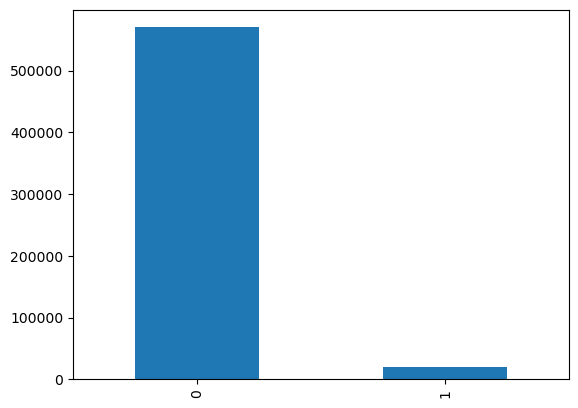

In [37]:
train_transaction['isFraud'].value_counts().plot(kind='bar')

This is a highly skewed dataset, with only 20k Fraud transactions present, compared to 569k non-fraud transactions.

# Email transactions & correlation to the 'isFraud' feature.

In [38]:
email_info = train_transaction[['P_emaildomain', 'R_emaildomain']]

In [39]:
email_info.isnull().sum()

P_emaildomain     94456
R_emaildomain    453249
dtype: int64

**Most values in the Recipient email domain are null.**

In [40]:
train_transaction[train_transaction['P_emaildomain'] == train_transaction['R_emaildomain']].shape[0]

102504

There are 102504 transactions where purchaser and recipient email domains are the same.

Now let's find out the number of columns where both are NOT NaN and both have DIFFERENT entries.

In [41]:
temp = train_transaction[~train_transaction['P_emaildomain'].isnull() & ~train_transaction['R_emaildomain'].isnull()]
temp[temp['P_emaildomain'] != temp['R_emaildomain']]

TransactionID  isFraud  TransactionDT  TransactionAmt ProductCD  \
197           2987197        0          89663            66.0         H   
236           2987236        0          90149            30.0         H   
271           2987271        0          90635            50.0         R   
332           2987332        0          91758           100.0         R   
335           2987335        0          91804           100.0         R   
...               ...      ...            ...             ...       ...   
590418        3577418        0       15808918           150.0         R   
590440        3577440        0       15809366           250.0         R   
590465        3577465        0       15809790           250.0         R   
590506        3577506        0       15810402           200.0         H   
590531        3577531        0       15810935           400.0         R   

        card1  card2  card3            issuer  card5  ... V310  V311  V312  \
197      7826  481.0  150.0        mastercard  224.0  ...  0.0   0.0   0.0   
236     10023  111.0  150.0              visa  226.0  ...  0.0   0.0   0.0   
271      9596  369.0  150.0        mastercard  224.0  ...  0.0   0.0   0.0   
332      9500  321.0  150.0              visa  226.0  ...  0.0   0.0   0.0   
335      9500  321.0  150.0              visa  226.0  ...  0.0   0.0   0.0   
...       ...    ...    ...               ...    ...  ...  ...   ...   ...   
590418   7903  399.0  150.0  american express  137.0  ...  0.0   0.0   0.0   
590440  18268  583.0  150.0              visa  226.0  ...  0.0   0.0   0.0   
590465  13309  399.0  150.0  american express  150.0  ...  0.0   0.0   0.0   
590506  16075  514.0  150.0        mastercard  102.0  ...  0.0   0.0   0.0   
590531   6019  583.0  150.0              visa  226.0  ...  0.0   0.0   0.0   

        V313 V314   V319   V320  V335   V337   V338  
197      0.0  0.0    0.0    0.0   0.0    0.0    0.0  
236      0.0  0.0    0.0    0.0   0.0    0.0    0.0  
271      0.0  0.0    0.0    0.0   0.0    0.0    0.0  
332      0.0  0.0    0.0    0.0   0.0    0.0    0.0  
335      0.0  0.0  100.0  100.0   0.0  100.0  100.0  
...      ...  ...    ...    ...   ...    ...    ...  
590418   NaN  NaN    0.0    0.0   0.0    0.0    0.0  
590440   NaN  NaN    0.0    0.0   0.0    0.0    0.0  
590465   NaN  NaN    0.0    0.0   0.0    0.0    0.0  
590506   NaN  NaN    0.0    0.0   0.0    0.0    0.0  
590531   NaN  NaN    0.0    0.0   0.0    0.0    0.0  

[23723 rows x 225 columns]

# Find the number of fraudulent transactions for occurrence of email domain as both purchaser and receiver.

In [42]:
# Calculate percentage of fraud transactions for every Purchaser email domain, and put the result into a dataframe.
purchaser_email_df = train_transaction.groupby(['P_emaildomain'])['isFraud'].value_counts(normalize=True).rename('counts').reset_index()

In [43]:
# train_transaction.groupby(['P_emaildomain'])['isFraud'].value_counts().reset_index()

In [44]:
purchaser_email_df

P_emaildomain  isFraud    counts
0          aim.com        0  0.873016
1          aim.com        1  0.126984
2    anonymous.com        0  0.976783
3    anonymous.com        1  0.023217
4          aol.com        0  0.978189
..             ...      ...       ...
96        yahoo.es        1  0.014925
97        yahoo.fr        0  0.965035
98        yahoo.fr        1  0.034965
99       ymail.com        0  0.979132
100      ymail.com        1  0.020868

[101 rows x 3 columns]

What proportion of emails from a given domain are fraud?

In [45]:
purchaser_email_df.groupby('isFraud')['counts'].value_counts()

isFraud  counts  
0        1.000000    17
         0.592105     1
         0.810376     1
         0.869863     1
         0.873016     1
                     ..
1        0.094584     1
         0.126984     1
         0.130137     1
         0.189624     1
         0.407895     1
Name: counts, Length: 85, dtype: int64

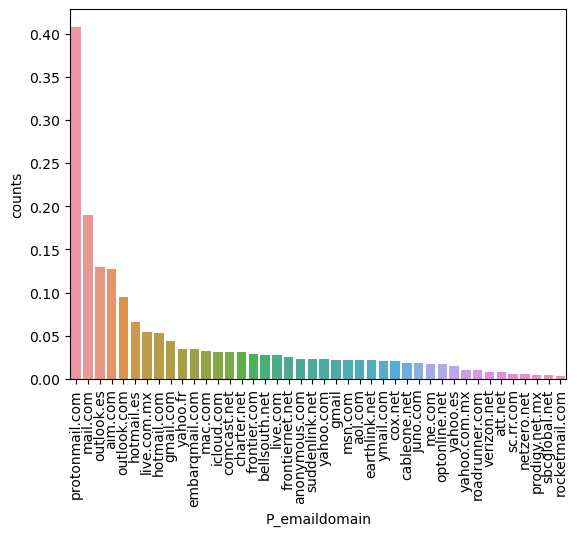

In [46]:
sns.barplot(data=purchaser_email_df[purchaser_email_df['isFraud']==1].sort_values('counts', ascending=False), x='P_emaildomain', y='counts')
ticks = plt.xticks(rotation=90)

~ 40% emails from the domain 'protonmail.com' are fraudulent. 2nd highest fraud rate is for the domain 'mail.com', at just less than 20%

## Purchaser email is an important feature.

In [47]:
train_transaction.groupby(['P_emaildomain', 'R_emaildomain'])['isFraud'].value_counts()

P_emaildomain  R_emaildomain  isFraud
aim.com        aim.com        0          12
                              1           1
               anonymous.com  0           6
               aol.com        0           7
               comcast.net    0           1
                                         ..
ymail.com      outlook.com    0           2
               verizon.net    0           2
               yahoo.com      0          24
               ymail.com      0          89
                              1           8
Name: isFraud, Length: 753, dtype: int64

In [48]:
# Grouping the number of fraudulent transactions per email domain, without dropping NaN values.
p_email_groupedby_fraud = train_transaction.groupby('isFraud', dropna=False)['P_emaildomain'].value_counts(sort=True, dropna=False)
r_email_groupedby_fraud = train_transaction.groupby('isFraud', dropna=False)['R_emaildomain'].value_counts(sort=True, dropna=False)

In [49]:
# Check fraudulent transactions for Recipient email
r_email_groupedby_fraud[1][:10]

R_emaildomain
NaN              9436
gmail.com        6811
hotmail.com      2140
yahoo.com         610
anonymous.com     598
outlook.com       414
icloud.com        180
aol.com           129
outlook.es         57
mail.com           46
Name: R_emaildomain, dtype: int64

<Axes: xlabel='P_emaildomain'>

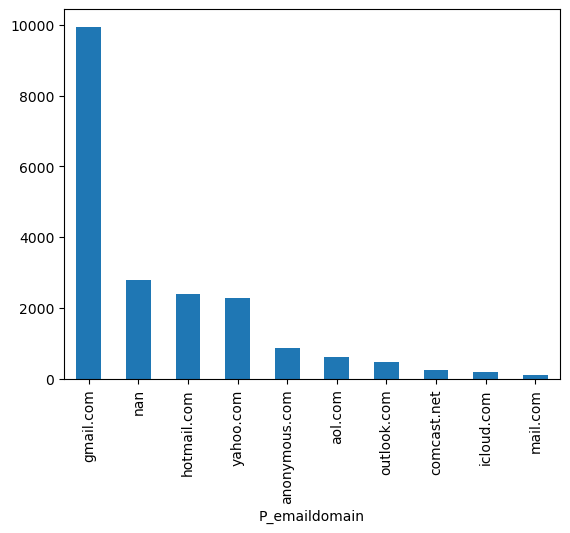

In [50]:
# Checking the number of purchaser email domains with most fraud transactions. index 1 contains email with isFraud=1
p_email_groupedby_fraud[1][:10].plot(kind='bar')
# sns.barplot(p_email_groupedby_fraud)

<Axes: xlabel='R_emaildomain'>

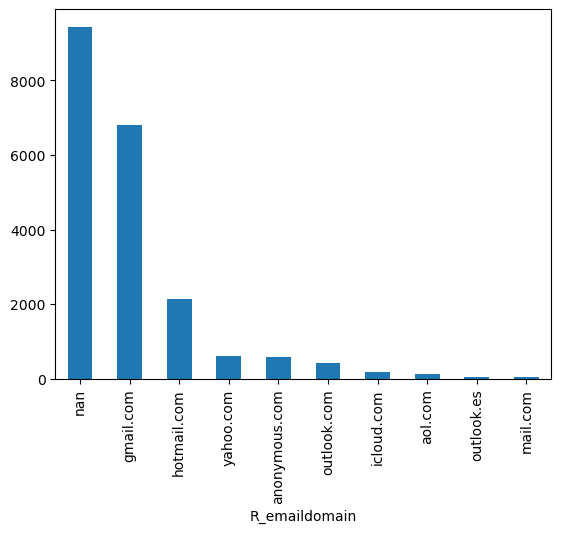

In [51]:
r_email_groupedby_fraud[1][:10].plot(kind='bar')

what i'm trying to do here is find out the number of fraudulent transactions when a given email domain occurs in the purchaser column and receiver column. plot domain name in the x-axis, count in the y-axis and have 2 plots per category: one for receiver and one for purchaser.

In [52]:
p_email_groupedby_fraud[1]

P_emaildomain
gmail.com          9943
NaN                2790
hotmail.com        2396
yahoo.com          2297
anonymous.com       859
aol.com             617
outlook.com         482
comcast.net         246
icloud.com          197
mail.com            106
msn.com              90
live.com             84
outlook.es           57
bellsouth.net        53
ymail.com            50
live.com.mx          41
aim.com              40
protonmail.com       31
att.net              30
cox.net              29
me.com               27
charter.net          25
verizon.net          22
hotmail.es           20
optonline.net        17
yahoo.com.mx         16
mac.com              14
sbcglobal.net        12
earthlink.net        11
gmail                11
embarqmail.com        9
frontier.com          8
juno.com              6
frontiernet.net       5
yahoo.fr              5
suddenlink.net        4
cableone.net          3
roadrunner.com        3
rocketmail.com        2
yahoo.es              2
netzero.net           1
pr

In [53]:
train_transaction.rename({'card4':'issuer', 'card6':'type'}, axis=1, inplace=True)

# Sort isFraud transactions based on card issuer company

In [54]:
issuer_groupedby_fraud = train_transaction.groupby('isFraud', dropna=False)['issuer'].value_counts(sort=True, dropna=False)

In [55]:
issuer_groupedby_fraud[1]

issuer
visa                13373
mastercard           6496
discover              514
american express      239
NaN                    41
Name: issuer, dtype: int64

<Axes: xlabel='issuer'>

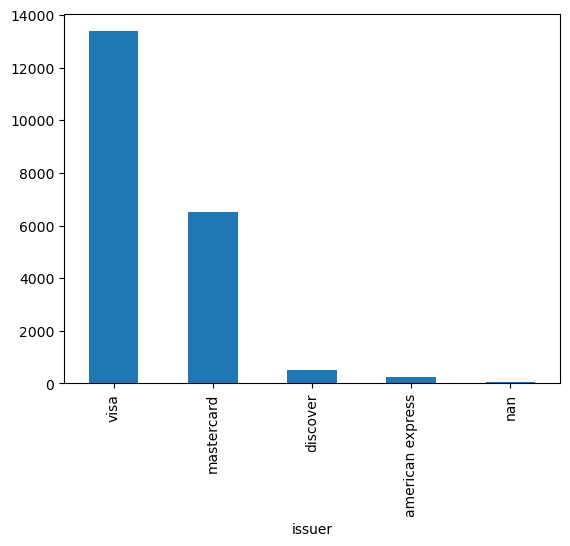

In [56]:
issuer_groupedby_fraud[1].plot(kind='bar')

VISA card has the most fraudulent transactions, followed by mastercard

<Axes: xlabel='issuer'>

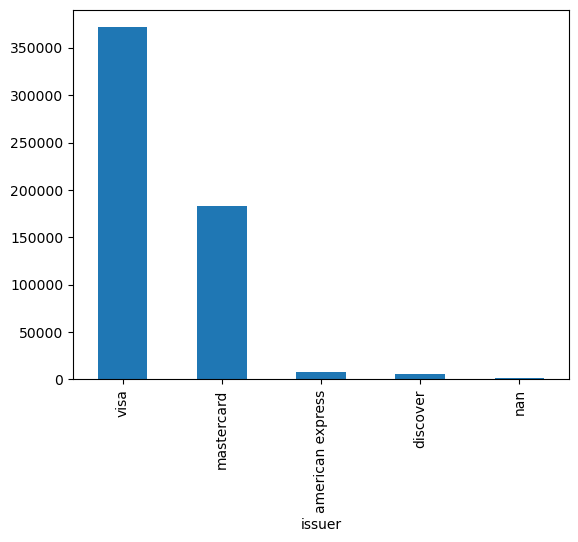

In [57]:
issuer_groupedby_fraud[0].plot(kind='bar')

Would be a good idea to plot percent of transactions per card issuer that are fraudulent.

In [58]:
issuer_groupedby_fraud

isFraud  issuer          
0        visa                371394
         mastercard          182721
         american express      8089
         discover              6137
         NaN                   1536
1        visa                 13373
         mastercard            6496
         discover               514
         american express       239
         NaN                     41
Name: issuer, dtype: int64

In [59]:
issuer_groupedby_fraud.groupby(['issuer', 'isFraud']).value_counts()

issuer            isFraud  issuer
american express  0        8089      1
                  1        239       1
discover          0        6137      1
                  1        514       1
mastercard        0        182721    1
                  1        6496      1
visa              0        371394    1
                  1        13373     1
Name: issuer, dtype: int64

In [60]:
email_df = train_transaction[['isFraud', 'issuer']]

In [61]:
email_df.groupby(['issuer']).value_counts()

issuer            isFraud
american express  0            8089
                  1             239
discover          0            6137
                  1             514
mastercard        0          182721
                  1            6496
visa              0          371394
                  1           13373
dtype: int64

<Axes: xlabel='issuer', ylabel='percentage'>

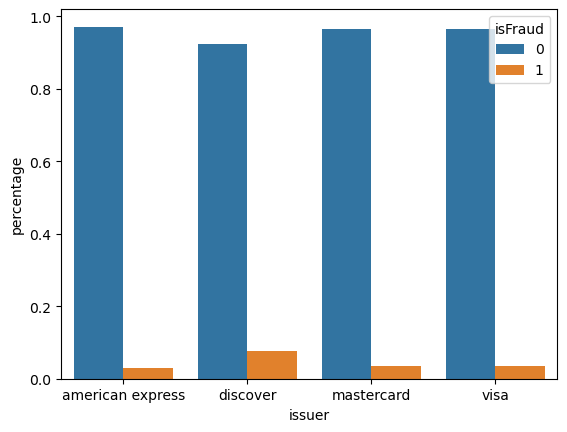

In [62]:
issuer_fraud_counts = email_df.groupby(['issuer']).value_counts(normalize=True).rename('percentage').reset_index()
sns.barplot(data=issuer_fraud_counts, x='issuer', y='percentage', hue='isFraud')

About 10% of Discover's transactions are fraudulent

In [63]:
train_transaction.columns

Index(['TransactionID', 'isFraud', 'TransactionDT', 'TransactionAmt',
       'ProductCD', 'card1', 'card2', 'card3', 'issuer', 'card5',
       ...
       'V310', 'V311', 'V312', 'V313', 'V314', 'V319', 'V320', 'V335', 'V337',
       'V338'],
      dtype='object', length=225)

# Analysis of the TransactionAmt/ TransactionDT feature

<Axes: xlabel='TransactionDT', ylabel='TransactionAmt'>

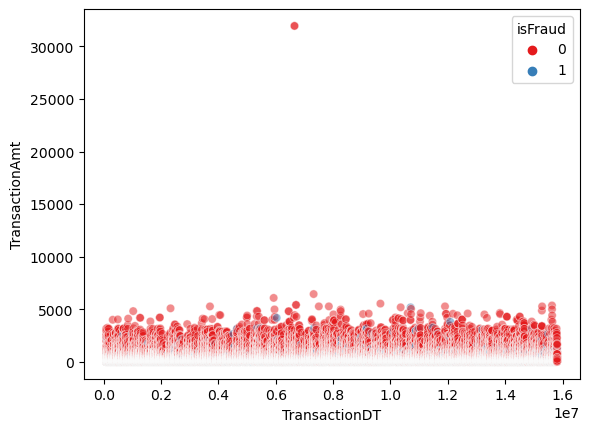

In [64]:
sns.scatterplot(data=train_transaction, x='TransactionDT', y='TransactionAmt', hue='isFraud', alpha=0.5, palette='Set1')

Most transactions are in a similar range, so it's difficult to determine whether a transaction is fraudulent or not solely based on the transaction amount. There is one outlier transaction here, which has been labeled as non-fraudulent.

In [65]:
train_transaction['day'] = ((train_transaction['TransactionDT']//(3600*24)-1)%7)+1

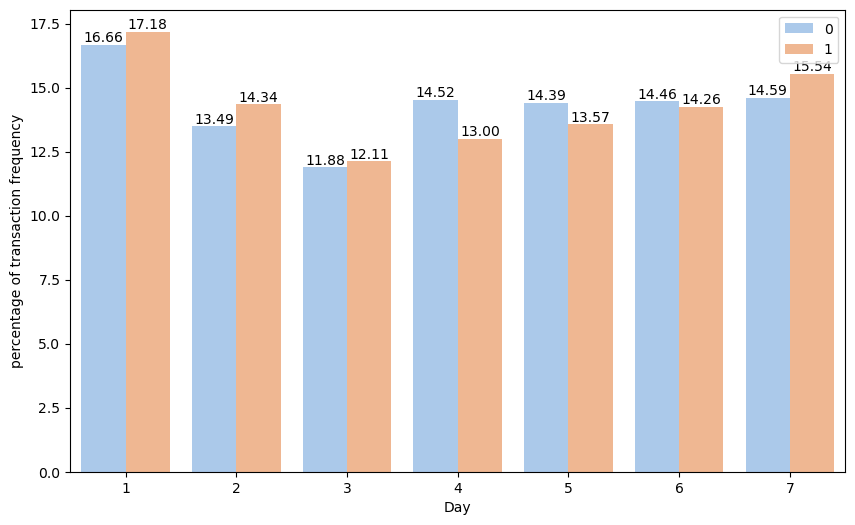

In [66]:
train_day = train_transaction.groupby('isFraud')['day'].value_counts(normalize=True).rename('percentage').mul(100).reset_index().sort_values('day')
plt.figure(figsize=(10,6))
barplot = sns.barplot(x="day", y="percentage", hue="isFraud", data=train_day, palette = 'pastel')
plt.legend()
plt.ylabel('percentage of transaction frequency')
plt.xlabel('Day')
for p in barplot.patches:
    barplot.annotate(format(p.get_height(), '.2f'), (p.get_x() + p.get_width() / 2., p.get_height()), ha = 'center', va = 'center', xytext = (0, 5), textcoords = 'offset points')
plt.show()

In [67]:
train_transaction.columns

Index(['TransactionID', 'isFraud', 'TransactionDT', 'TransactionAmt',
       'ProductCD', 'card1', 'card2', 'card3', 'issuer', 'card5',
       ...
       'V311', 'V312', 'V313', 'V314', 'V319', 'V320', 'V335', 'V337', 'V338',
       'day'],
      dtype='object', length=226)

In [68]:
train_transaction

TransactionID  isFraud  TransactionDT  TransactionAmt ProductCD  \
0             2987000        0          86400           68.50         W   
1             2987001        0          86401           29.00         W   
2             2987002        0          86469           59.00         W   
3             2987003        0          86499           50.00         W   
4             2987004        0          86506           50.00         H   
...               ...      ...            ...             ...       ...   
590535        3577535        0       15811047           49.00         W   
590536        3577536        0       15811049           39.50         W   
590537        3577537        0       15811079           30.95         W   
590538        3577538        0       15811088          117.00         W   
590539        3577539        0       15811131          279.95         W   

        card1  card2  card3      issuer  card5  ... V311   V312        V313  \
0       13926    NaN  150.0    discover  142.0  ...  0.0    0.0    0.000000   
1        2755  404.0  150.0  mastercard  102.0  ...  0.0    0.0    0.000000   
2        4663  490.0  150.0        visa  166.0  ...  0.0    0.0    0.000000   
3       18132  567.0  150.0  mastercard  117.0  ...  0.0  135.0    0.000000   
4        4497  514.0  150.0  mastercard  102.0  ...  0.0    0.0    0.000000   
...       ...    ...    ...         ...    ...  ...  ...    ...         ...   
590535   6550    NaN  150.0        visa  226.0  ...  0.0    0.0   47.950001   
590536  10444  225.0  150.0  mastercard  224.0  ...  0.0    0.0    0.000000   
590537  12037  595.0  150.0  mastercard  224.0  ...  0.0    0.0    0.000000   
590538   7826  481.0  150.0  mastercard  224.0  ...  0.0  117.0  317.500000   
590539  15066  170.0  150.0  mastercard  102.0  ...  0.0    0.0    0.000000   

              V314        V319        V320  V335  V337  V338  day  
0         0.000000    0.000000    0.000000   NaN   NaN   NaN    1  
1         0.000000    0.000000    0.000000   NaN   NaN   NaN    1  
2         0.000000    0.000000    0.000000   NaN   NaN   NaN    1  
3         0.000000    0.000000    0.000000   NaN   NaN   NaN    1  
4         0.000000    0.000000    0.000000   0.0   0.0   0.0    1  
...            ...         ...         ...   ...   ...   ...  ...  
590535   47.950001    0.000000    0.000000   NaN   NaN   NaN    7  
590536    0.000000    0.000000    0.000000   NaN   NaN   NaN    7  
590537    0.000000    0.000000    0.000000   NaN   NaN   NaN    7  
590538  669.500000    0.000000    0.000000   NaN   NaN   NaN    7  
590539    0.000000  279.950012  279.950012   NaN   NaN   NaN    7  

[590540 rows x 226 columns]

In [69]:
train_merged = train_transaction.merge(train_identity, how='left', on='TransactionID')

In [70]:
train_merged.columns

Index(['TransactionID', 'isFraud', 'TransactionDT', 'TransactionAmt',
       'ProductCD', 'card1', 'card2', 'card3', 'issuer', 'card5',
       ...
       'id_31', 'id_32', 'id_33', 'id_34', 'id_35', 'id_36', 'id_37', 'id_38',
       'DeviceType', 'DeviceInfo'],
      dtype='object', length=257)

In [71]:
train_merged.loc[:, 'V1':'V338'].fillna(-999, inplace=True)

In [72]:
train_merged.shape

(590540, 257)

# Count values

In [73]:
transaction_c = train_merged.loc[:, 'C1':'C14']
transaction_c_with_isfraud = pd.concat([transaction_c, train_merged['isFraud']], axis=1)

In [74]:
def get_unique_values(df):
    for col, values in df.items():
        print("\n\n", col, values.dtype)
        print("No. of unique values: ", values.nunique(), "\n", "List of unique values", values.unique())
        if values.dtype in [int, float]:
            print("Min", values.min(), "\tMax", values.max(), "\n")

In [75]:
px.imshow(transaction_c_with_isfraud.corr())

In [76]:
c_correlation = transaction_c.corr()
px.imshow(c_correlation)

In [77]:
c_list, _ = correlated_features(c_correlation, 0.9, col_name='C')

correlation for  1 ['C1', 'C2', 'C4', 'C6', 'C7', 'C8', 'C10', 'C11', 'C12', 'C14']
correlation for  3 ['C3']
correlation for  5 ['C5', 'C9']
correlation for  13 ['C13']


**C columns are not LINEARLY correlated to isFraud. However, there may be a non-linear relationship here.**

**What we CAN deduce here is that many columns in the 'C' category are LINEARLY correlated. This means, we can group highly correlated features together, and select only one feature as a representative of the group.**

In [78]:
list_to_drop = [i for i in transaction_c.columns if i not in c_list]

In [79]:
list_to_drop

['C2', 'C4', 'C6', 'C7', 'C8', 'C9', 'C10', 'C11', 'C12', 'C14']

In [80]:
train_merged.drop(list_to_drop, axis=1, inplace=True)

In [81]:
train_merged.shape

(590540, 247)

In [82]:
px.imshow(train_merged.loc[:, 'C1':'C13'].corr())

## Went from 117 to 106.

In [83]:
train_merged.loc[:, 'C1':'C13']

C1   C3   C5   C13
0       1.0  0.0  0.0   1.0
1       1.0  0.0  0.0   1.0
2       1.0  0.0  0.0   1.0
3       2.0  0.0  0.0  25.0
4       1.0  0.0  0.0   1.0
...     ...  ...  ...   ...
590535  2.0  0.0  1.0   3.0
590536  1.0  0.0  0.0   1.0
590537  1.0  0.0  1.0   1.0
590538  1.0  0.0  0.0   5.0
590539  2.0  0.0  1.0   1.0

[590540 rows x 4 columns]

**Interestingly, there are no null values in the *C* columns.**

# M COLUMN ANALYSIS

In [84]:
train_merged['isFraud']

0         0
1         0
2         0
3         0
4         0
         ..
590535    0
590536    0
590537    0
590538    0
590539    0
Name: isFraud, Length: 590540, dtype: int64

In [85]:
m_columns = train_merged.loc[:, 'M1':'M9']
m_columns = pd.concat([m_columns, train_merged['isFraud']])

M columns are matches between names on card and address, and so on. Masked.

Mx is attribute of matching check, e.g. is phone areacode matched with billing zipcode, purchaser and recipient first/or last name match, etc.

In [86]:
for col, values in  m_columns.items():
    print(col, values.unique())

M1 ['T' nan 'F']
M2 ['T' nan 'F']
M3 ['T' nan 'F']
M4 ['M2' 'M0' nan 'M1']
M5 ['F' 'T' nan]
M6 ['T' 'F' nan]
M7 [nan 'F' 'T']
M8 [nan 'F' 'T']
M9 [nan 'F' 'T']
0 [nan  0.  1.]


No of categories = 10. So our dof is 9.
Assuming an alpha value of 0.05, we need to find out the chi square value.

In [87]:
train_transaction.loc[:, :'type'].columns

Index(['TransactionID', 'isFraud', 'TransactionDT', 'TransactionAmt',
       'ProductCD', 'card1', 'card2', 'card3', 'issuer', 'card5', 'type'],
      dtype='object')

<Axes: xlabel='type', ylabel='TransactionAmt'>

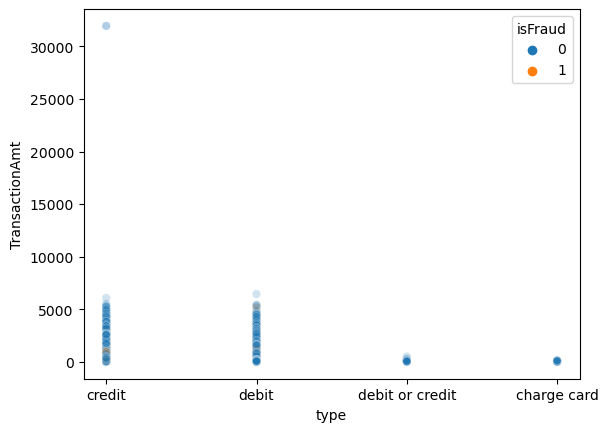

In [88]:
sns.scatterplot(data=train_transaction, x='type', y='TransactionAmt', hue='isFraud', alpha=0.2)

<Axes: xlabel='type', ylabel='TransactionAmt'>

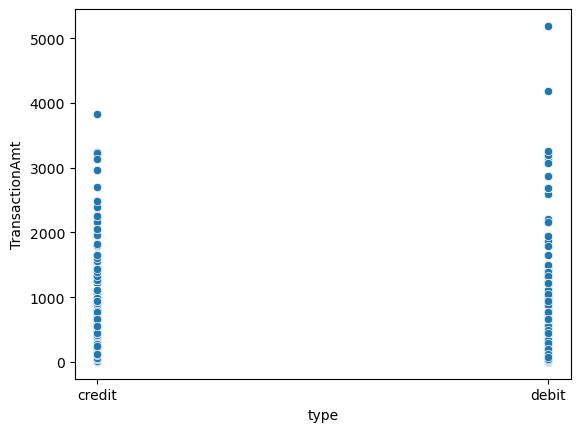

In [89]:
sns.scatterplot(data=train_transaction[train_transaction['isFraud']==1], x='type', y='TransactionAmt')

In [90]:
train_transaction[train_transaction['type']=='debit or credit']['isFraud'].value_counts()

0    30
Name: isFraud, dtype: int64

In [91]:
train_transaction[train_transaction['type']=='charge card']['isFraud'].value_counts()

0    15
Name: isFraud, dtype: int64

**Apparently, there are no fraud transactions when 'type' = 'chargecard' and 'type' = 'debit or credit' - a total of 45 entries for both. Maybe we can drop these entries?**

In [92]:
train_merged[(train_merged['type'] == 'chargecard') | (train_merged['type'] == 'debit or credit')].reset_index()

index  TransactionID  isFraud  TransactionDT  TransactionAmt ProductCD  \
0    16408        3003408        0         435569           58.51         W   
1    27859        3014859        0         695531           25.00         W   
2    43216        3030216        0        1036297           58.43         W   
3    54633        3041633        0        1279292          512.61         W   
4    61895        3048895        0        1393922          160.47         W   
5    67872        3054872        0        1539141          108.43         W   
6    81130        3068130        0        1737181           57.95         W   
7   110482        3097482        0        2159314           30.95         W   
8   134726        3121726        0        2685444          108.43         W   
9   137320        3124320        0        2764794           50.95         W   
10  197640        3184640        0        4471820          108.43         W   
11  201487        3188487        0        4586031          104.01         W   
12  215877        3202877        0        5013664           30.95         W   
13  219394        3206394        0        5157175           58.95         W   
14  225017        3212017        0        5324708           25.95         W   
15  256701        3243701        0        6141028           57.95         W   
16  259306        3246306        0        6215407           25.95         W   
17  311483        3298483        0        7757001          331.00         W   
18  322832        3309832        0        8012422          107.95         W   
19  322886        3309886        0        8012678          107.95         W   
20  331989        3318989        0        8180196           25.95         W   
21  340607        3327607        0        8381128          280.00         W   
22  347948        3334948        0        8566416          178.50         W   
23  365860        3352860        0        9076694          105.95         W   
24  376300        3363300        0        9405509           57.95         W   
25  384002        3371002        0        9636042           57.95         W   
26  392900        3379900        0        9851985           30.95         W   
27  396390        3383390        0        9989374          115.00         W   
28  396405        3383405        0        9989568          107.95         W   
29  416148        3403148        0       10516643           30.95         W   

    card1  card2  card3      issuer  ...  id_31 id_32  id_33  id_34  id_35  \
0    4648  555.0  150.0  mastercard  ...    NaN   NaN    NaN    NaN    NaN   
1    2572  555.0  150.0  mastercard  ...    NaN   NaN    NaN    NaN    NaN   
2    4648  555.0  150.0  mastercard  ...    NaN   NaN    NaN    NaN    NaN   
3    4648  555.0  150.0  mastercard  ...    NaN   NaN    NaN    NaN    NaN   
4    4648  555.0  150.0  mastercard  ...    NaN   NaN    NaN    NaN    NaN   
5    4648  555.0  150.0  mastercard  ...    NaN   NaN    NaN    NaN    NaN   
6    2572  555.0  150.0  mastercard  ...    NaN   NaN    NaN    NaN    NaN   
7    2572  555.0  150.0  mastercard  ...    NaN   NaN    NaN    NaN    NaN   
8    4648  555.0  150.0  mastercard  ...    NaN   NaN    NaN    NaN    NaN   
9    2572  555.0  150.0  mastercard  ...    NaN   NaN    NaN    NaN    NaN   
10   4648  555.0  150.0  mastercard  ...    NaN   NaN    NaN    NaN    NaN   
11   4648  555.0  150.0  mastercard  ...    NaN   NaN    NaN    NaN    NaN   
12   2572  555.0  150.0  mastercard  ...    NaN   NaN    NaN    NaN    NaN   
13   4648  555.0  150.0  mastercard  ...    NaN   NaN    NaN    NaN    NaN   
14   2572  555.0  150.0  mastercard  ...    NaN   NaN    NaN    NaN    NaN   
15   4648  555.0  150.0  mastercard  ...    NaN   NaN    NaN    NaN    NaN   
16   2572  555.0  150.0  mastercard  ...    NaN   NaN    NaN    NaN    NaN   
17   4648  555.0  150.0  mastercard  ...    NaN   NaN    NaN    NaN    NaN   
18   2572  555.0  150.0  mastercard  ...    NaN   NaN    NaN    NaN    Na

In [93]:
train_merged.shape

(590540, 247)

In [94]:
train_merged.drop(train_merged[(train_merged['type'] == 'chargecard') | (train_merged['type'] == 'debit or credit')].reset_index()['index'], inplace=True)

In [95]:
train_merged.shape

(590510, 247)

# EXPORT MERGED DATAFRAME TO A CSV FILE

In [96]:
train_merged.to_csv('engineered_train.csv')

In [97]:
train_transaction.loc[:, 'C1':'V1']

C1   C2   C3   C4   C5   C6   C7   C8   C9  C10  ...   M1   M2   M3  \
0       1.0  1.0  0.0  0.0  0.0  1.0  0.0  0.0  1.0  0.0  ...    T    T    T   
1       1.0  1.0  0.0  0.0  0.0  1.0  0.0  0.0  0.0  0.0  ...  NaN  NaN  NaN   
2       1.0  1.0  0.0  0.0  0.0  1.0  0.0  0.0  1.0  0.0  ...    T    T    T   
3       2.0  5.0  0.0  0.0  0.0  4.0  0.0  0.0  1.0  0.0  ...  NaN  NaN  NaN   
4       1.0  1.0  0.0  0.0  0.0  1.0  0.0  1.0  0.0  1.0  ...  NaN  NaN  NaN   
...     ...  ...  ...  ...  ...  ...  ...  ...  ...  ...  ...  ...  ...  ...   
590535  2.0  1.0  0.0  0.0  1.0  0.0  0.0  0.0  2.0  0.0  ...    T    T    T   
590536  1.0  1.0  0.0  0.0  0.0  1.0  0.0  0.0  1.0  0.0  ...    T    F    F   
590537  1.0  1.0  0.0  0.0  1.0  1.0  0.0  0.0  1.0  0.0  ...    T    F    F   
590538  1.0  1.0  0.0  0.0  0.0  3.0  0.0  0.0  2.0  0.0  ...    T    T    T   
590539  2.0  1.0  0.0  0.0  1.0  1.0  0.0  0.0  2.0  0.0  ...    T    F    F   

         M4   M5   M6   M7   M8   M9   V1  
0        M2    F    T  NaN  NaN  NaN  1.0  
1        M0    T    T  NaN  NaN  NaN  NaN  
2        M0    F    F    F    F    F  1.0  
3        M0    T    F  NaN  NaN  NaN  NaN  
4       NaN  NaN  NaN  NaN  NaN  NaN  NaN  
...     ...  ...  ...  ...  ...  ...  ...  
590535   M0    T    F    F    F    T  1.0  
590536   M0    F    T    F    F    F  1.0  
590537  NaN  NaN    T  NaN  NaN  NaN  1.0  
590538   M0    F    T  NaN  NaN  NaN  1.0  
590539  NaN  NaN    T    F    F    F  1.0  

[590540 rows x 32 columns]

In [98]:
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split

# Identity table EDA

Feeding a few features (except V columns) to the LR model, by min max scaling the values first. categorical variables will be one hot encoded.

id 12-38 are categorical variables
id 1-11 are numeric

In [99]:
train_identity

TransactionID  id_01     id_02  id_03  id_04  id_05  id_06  id_09  \
0             2987004    0.0   70787.0    NaN    NaN    NaN    NaN    NaN   
1             2987008   -5.0   98945.0    NaN    NaN    0.0   -5.0    NaN   
2             2987010   -5.0  191631.0    0.0    0.0    0.0    0.0    0.0   
3             2987011   -5.0  221832.0    NaN    NaN    0.0   -6.0    NaN   
4             2987016    0.0    7460.0    0.0    0.0    1.0    0.0    0.0   
...               ...    ...       ...    ...    ...    ...    ...    ...   
144228        3577521  -15.0  145955.0    0.0    0.0    0.0    0.0    0.0   
144229        3577526   -5.0  172059.0    NaN    NaN    1.0   -5.0    NaN   
144230        3577529  -20.0  632381.0    NaN    NaN   -1.0  -36.0    NaN   
144231        3577531   -5.0   55528.0    0.0    0.0    0.0   -7.0    0.0   
144232        3577534  -45.0  339406.0    NaN    NaN  -10.0 -100.0    NaN   

        id_10  id_11  ...                    id_31  id_32      id_33  \
0         NaN  100.0  ...      samsung browser 6.2   32.0  2220x1080   
1         NaN  100.0  ...       mobile safari 11.0   32.0   1334x750   
2         0.0  100.0  ...              chrome 62.0    NaN        NaN   
3         NaN  100.0  ...              chrome 62.0    NaN        NaN   
4         0.0  100.0  ...              chrome 62.0   24.0   1280x800   
...       ...    ...  ...                      ...    ...        ...   
144228    0.0  100.0  ...  chrome 66.0 for android    NaN        NaN   
144229    NaN  100.0  ...  chrome 55.0 for android   32.0    855x480   
144230    NaN  100.0  ...  chrome 65.0 for android    NaN        NaN   
144231    0.0  100.0  ...              chrome 66.0   24.0  2560x1600   
144232    NaN  100.0  ...  chrome 66.0 for android    NaN        NaN   

                 id_34 id_35  id_36  id_37  id_38  DeviceType  \
0       match_status:2     T      F      T      T      mobile   
1       match_status:1     T      F      F      T      mobile   
2                  NaN     F      F      T      T     desktop   
3                  NaN     F      F      T      T     desktop   
4       match_status:2     T      F      T      T     desktop   
...                ...   ...    ...    ...    ...         ...   
144228             NaN     F      F      T      F      mobile   
144229  match_status:2     T      F      T      F      mobile   
144230             NaN     F      F      T      F      mobile   
144231  match_status:2     T      F      T      F     desktop   
144232             NaN     F      F      T      F      mobile   

                                DeviceInfo  
0            SAMSUNG SM-G892A Build/NRD90M  
1                               iOS Device  
2                                  Windows  
3                                      NaN  
4                                    MacOS  
...                                    ...  
144228             F3111 Build/33.3.A.1.97  
144229                 A574BL Build/NMF26F  
144230  Moto E (4) Plus Build/NMA26.42-152  
144231                               MacOS  
144232         RNE-L03 Build/HUAWEIRNE-L03  

[144233 rows x 32 columns]

In [100]:
train_merged.shape

(590510, 247)

In [101]:
train_merged.head()

TransactionID  isFraud  TransactionDT  TransactionAmt ProductCD  card1  \
0        2987000        0          86400            68.5         W  13926   
1        2987001        0          86401            29.0         W   2755   
2        2987002        0          86469            59.0         W   4663   
3        2987003        0          86499            50.0         W  18132   
4        2987004        0          86506            50.0         H   4497   

   card2  card3      issuer  card5  ...                id_31  id_32  \
0    NaN  150.0    discover  142.0  ...                  NaN    NaN   
1  404.0  150.0  mastercard  102.0  ...                  NaN    NaN   
2  490.0  150.0        visa  166.0  ...                  NaN    NaN   
3  567.0  150.0  mastercard  117.0  ...                  NaN    NaN   
4  514.0  150.0  mastercard  102.0  ...  samsung browser 6.2   32.0   

       id_33           id_34 id_35 id_36  id_37  id_38  DeviceType  \
0        NaN             NaN   NaN   NaN    NaN    NaN         NaN   
1        NaN             NaN   NaN   NaN    NaN    NaN         NaN   
2        NaN             NaN   NaN   NaN    NaN    NaN         NaN   
3        NaN             NaN   NaN   NaN    NaN    NaN         NaN   
4  2220x1080  match_status:2     T     F      T      T      mobile   

                      DeviceInfo  
0                            NaN  
1                            NaN  
2                            NaN  
3                            NaN  
4  SAMSUNG SM-G892A Build/NRD90M  

[5 rows x 247 columns]

In [102]:
pd.set_option("display.max_columns", 0)
i = train_merged.loc[:,'id_12':'id_38']
get_unique_values(i)



 id_12 object
No. of unique values:  2 
 List of unique values [nan 'NotFound' 'Found']


 id_13 float64
No. of unique values:  54 
 List of unique values [nan 49. 52. 14. 20. 55. 43. 18. 41. 63. 61. 35. 25. 39. 57. 15. 11. 44.
 62. 59. 28. 24. 51. 60. 54. 36. 38. 31. 56. 58. 22. 50. 32. 45. 48. 23.
 30. 17. 13. 37. 21. 46. 10. 26. 53. 34. 47. 33. 40. 29. 19. 64. 12. 27.
 42.]
Min 10.0 	Max 64.0 



 id_14 float64
No. of unique values:  25 
 List of unique values [  nan -480. -300. -360. -420. -540. -600.  480. -240.  300. -180.   60.
    0.  180.  540.  600.  420.  270.  120.  240.  330. -120.  360.  720.
 -660. -210.]
Min -660.0 	Max 720.0 



 id_15 object
No. of unique values:  3 
 List of unique values [nan 'New' 'Found' 'Unknown']


 id_16 object
No. of unique values:  2 
 List of unique values [nan 'NotFound' 'Found']


 id_17 float64
No. of unique values:  104 
 List of unique values [ nan 166. 121. 225. 102. 148. 199. 146. 144. 133. 100. 130. 218. 150.
 195. 153. 159. 142. 2